In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

## Load Dataset

In [ ]:
#unzip dataset to dataset folder
os.system('unzip -o dataset/Small-Retinoblastoma-Dataset.zip -d dataset/')
#os.system('unzip -o Retinoblastoma-Dataset.zip') #run this row instead if you use google colab

In [ ]:
os.system('unzip -o Retinoblastoma-Dataset.zip')

In [3]:
# Current directory
cwd = os.getcwd()

# base directory for dataset
base_dir = os.path.join(cwd, 'dataset/Retinoblastoma-Dataset/')
#base_dir = os.path.join(cwd, 'dataset/Small-Retinoblastoma-Dataset/') #run this row instead if you use google colab 

train_dir = os.path.join(base_dir, 'training') # training set directory
validation_dir = os.path.join(base_dir, 'validation') # validation set directory
test_dir = os.path.join(base_dir, 'testing') # testing set directory

In [4]:
# assign class names in training set to each variable
train_normal_eyes_dir = os.path.join(train_dir, 'normal')
train_retinoblastoma_dir = os.path.join(train_dir, 'retinoblastoma')

# assign class names in validation set to each variable
validation_normal_eyes_dir = os.path.join(validation_dir, 'normal')
validation_retinoblastoma_dir  = os.path.join(validation_dir, 'retinoblastoma')

# assign class names in testing set to each variable
test_normal_eyes_dir = os.path.join(test_dir, 'normal')
test_retinoblastoma_dir = os.path.join(test_dir, 'retinoblastoma')

# Count the number of images in each category
train_normal_eyes = len(os.listdir(train_normal_eyes_dir))
train_retinoblastoma = len(os.listdir(train_retinoblastoma_dir))
validation_normal_eyes = len(os.listdir(validation_normal_eyes_dir))
validation_retinoblastoma = len(os.listdir(validation_retinoblastoma_dir))
test_normal_eyes = len(os.listdir(test_normal_eyes_dir))
test_retinoblastoma = len(os.listdir(test_retinoblastoma_dir))


print(train_normal_eyes + train_retinoblastoma, ' Size of Trains')
print(validation_normal_eyes + validation_retinoblastoma, ' Size of Validations')
print(test_normal_eyes + test_retinoblastoma, ' Size of Tests')

535  Size of Trains
50  Size of Validations
40  Size of Tests


## image augmentation

In [59]:
# import ImageDataGenerator library
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# pre-process the data using ImageDataGenerator with vgg16 preprocessing function 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

Function for augmenting the image

In [60]:
 #use class_mode = 'categorical' if want to use multiclass classification'
 #use class_mode = 'binary' if want to use binary class classification

def data_augment(train_datagen, class_mode='categorical'):
 
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # this is the target directory
          target_size=(224, 224),  # set image size to 224x224 for input
          batch_size=24, # set batch size to 24
          class_mode= class_mode # set to 'categorical' if want to use multiclass output
          )

  validation_generator = train_datagen.flow_from_directory(
          validation_dir,
          target_size=(224, 224),
          batch_size=24,
          class_mode= class_mode 
          )

  test_generator = train_datagen.flow_from_directory(
           test_dir,
           target_size=(224, 224),
           batch_size=24,
           class_mode=class_mode
           )

  return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = data_augment(train_datagen, 'categorical')

Found 511 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


looking at the augmented data

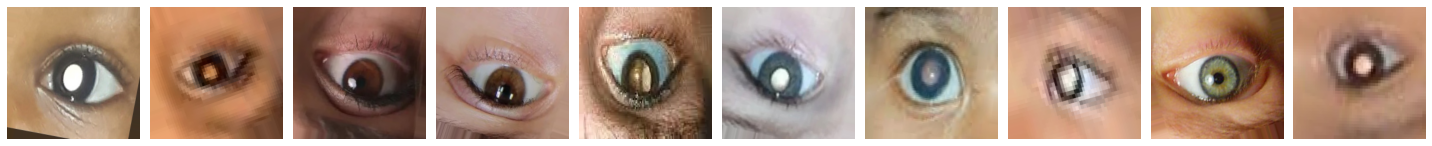

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [61]:
img, labels = next(train_generator)

#function for plotting images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(img)
print(labels[0:10])

## source model

Using VGG16 as a source model for transfer learrning


In [48]:
from tensorflow.keras.applications.vgg16 import VGG16

#using VGG16 pre-trained model with weights trained on imagenet
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

In [19]:
last_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

## create model

Function for creating model architecture

In [49]:
#base_model = source model for transfer learning
#last_output = output layer of the source model
#output_type = binary / multiclass

def create_model(base_model, last_output, output_type, model=2):

  #choose an output layer type
  #using multiclass output
  if output_type == 'multiclass':
    activation_funct = 'softmax' 
    output_layer = 2
    loss = tf.keras.losses.CategoricalCrossentropy()

  #using binary output
  elif output_type == 'binary':
    activation_funct = 'sigmoid'
    output_layer = 1
    loss=tf.keras.losses.BinaryCrossentropy()

  # choose model architecture
  # Using the last layer of the VGG16 model, we can create a new model that will be used for our transfer learning.
  if model == 1:
    layer = tf.keras.layers.GlobalAveragePooling2D()(last_output)
    layer = tf.keras.layers.Dense(256, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(128, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(output_layer, activation=activation_funct)(layer)

    model = tf.keras.Model(base_model.inputs, layer)

  # sequentials model with VGG16 pre-trained model
  elif model == 2:
    model = tf.keras.models.Sequential([ 
      base_model,                
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output_layer, activation=activation_funct)
      ])

  #compile model 
  model.compile(loss = loss, 
                optimizer=tf.optimizers.Adam(),
                metrics=['accuracy'])
  
  #return model
  return model

Function for showing the architecture of the model

In [50]:
# show the architecture of the model
def summary_model(model):
  return model.summary()

callbacks

In [51]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.95) and (logs.get('accuracy') >= 0.95):
      print("\Akurasi Maksimum!")
      self.model.stop_training = True

callbacks = myCallback()


Function for training the model

In [52]:
# train the model
def train_model(model, train_generator, validation_generator, callbacks = callbacks, epochs=20, verbose=2):
  
  history = model.fit(
      train_generator,
      epochs=epochs, 
      validation_data=validation_generator,
      verbose=verbose,
      callbacks=[callbacks])
  
  return history

## train and evaluate model

Create and show the model architecture

In [53]:
#train the model with VGG16 pre-trained model and multiclass output
model = create_model(base_model, last_output, 'multiclass', 2)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 14,879,170
Trainable params: 164,482
Non-trainable params: 14,714,688
____________________________________

Train the model

In [14]:
train_model(model, train_generator, validation_generator, callbacks, 15)

2022-06-26 12:05:19.778275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 12:05:19.782900: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
22/22 - 72s - loss: 0.6521 - accuracy: 0.6008 - val_loss: 0.6444 - val_accuracy: 0.6458
Epoch 2/15
22/22 - 86s - loss: 0.5761 - accuracy: 0.6947 - val_loss: 0.6851 - val_accuracy: 0.5833
Epoch 3/15
22/22 - 99s - loss: 0.5390 - accuracy: 0.7378 - val_loss: 0.5877 - val_accuracy: 0.7500
Epoch 4/15
22/22 - 96s - loss: 0.4643 - accuracy: 0.7847 - val_loss: 0.5587 - val_accuracy: 0.6875
Epoch 5/15
22/22 - 95s - loss: 0.4349 - accuracy: 0.7984 - val_loss: 0.4724 - val_accuracy: 0.7917
Epoch 6/15
22/22 - 97s - loss: 0.4037 - accuracy: 0.8023 - val_loss: 0.5010 - val_accuracy: 0.7500
Epoch 7/15
22/22 - 96s - loss: 0.3858 - accuracy: 0.8415 - val_loss: 0.4220 - val_accuracy: 0.7708
Epoch 8/15
22/22 - 114s - loss: 0.3489 - accuracy: 0.8474 - val_loss: 0.4494 - val_accuracy: 0.7917
Epoch 9/15
22/22 - 130s - loss: 0.3259 - accuracy: 0.8493 - val_loss: 0.3831 - val_accuracy: 0.8125
Epoch 10/15
22/22 - 121s - loss: 0.2813 - accuracy: 0.8845 - val_loss: 0.2442 - val_accuracy: 0.9375
Epoch 

Evaluate model with test data

In [15]:
model.evaluate(test_generator)

2/2 [==============================] - 9s 3s/step - loss: 0.2755 - accuracy: 0.8919


[0.2755473852157593, 0.8918918967247009]

Evaluate the true negative and false positive

In [28]:
from tensorflow.keras.preprocessing import image

#normal test directory
normal_test_dir = os.path.join(test_dir, 'normal')
normal = 0
retinoblastoma = 0

#iterate through the normal test directory
for images_path in os.listdir(normal_test_dir):
    path = images_path

    if path == '.DS_Store':
        continue
    
    #load the image
    img = image.load_img(os.path.join(normal_test_dir, path), target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    #predict the image
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    #if the image is predicted normal
    if round(float(classes[0][0])) == 1:
        normal = normal + 1

    #if the image is predicted retinoblastoma
    elif round(float(classes[0][1])) == 1:
        retinoblastoma = retinoblastoma + 1

#print total case and predicted case
print('Total normal case: ', retinoblastoma+normal)
print('Total case predicted correctly: ', normal)
print('Total case predicted incorrectly: ', retinoblastoma)

#print true negative, and false positive rate
true_negative = normal / (normal + retinoblastoma) * 100
print("True Negative Rate: {:.1f}%".format(true_negative))

false_positive = retinoblastoma / (normal + retinoblastoma) * 100
print("False Positive Rate: {:.1f}%".format(false_positive))


Total normal case:  24
Total case predicted correctly:  18
Total case predicted incorrectly:  6
True Negative Rate: 75.0%
False Positive Rate: 25.0%


We get 75% True negative rate and 25% false positive rate

-----------------
Evaluate the true positive and false negative rate

In [29]:
#retinoblastoma test directory
retinoblastoma_test_dir = os.path.join(test_dir, 'retinoblastoma')
normal = 0
retinoblastoma = 0

#iterate through the retinoblastoma test directory
for images_path in os.listdir(retinoblastoma_test_dir):
    path = images_path

    if path == '.DS_Store':
        continue

    #load image
    img = image.load_img(os.path.join(retinoblastoma_test_dir, path), target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    #predict image
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    #if the image is predicted normal
    if round(float(classes[0][0])) == 1:
        normal += 1

    #if the image is predicted retinoblastoma
    elif round(float(classes[0][1])) == 1:
        retinoblastoma += 1

#print total case and predicted case
print('Total retinoblastoma case: ', retinoblastoma+normal)
print('Total case predicted correctly: ', retinoblastoma)
print('Total case predicted incorrectly: ', normal)

#print true negative, and false positive rate
true_positive = retinoblastoma / (retinoblastoma + normal) * 100
print("True Positive Rate: {:.1f}%".format(true_positive))

false_negative = normal / (retinoblastoma + normal) * 100
print("False Negative Rate: {:.1f}%".format(false_negative))

Total retinoblastoma case:  14
Total case predicted correctly:  11
Total case predicted incorrectly:  3
True Positive Rate: 78.6%
False Negative Rate: 21.4%


We get 78,6% True positive rate and 21.4% False negative rate

---------------------
## Prediction

Run this cell below if running the notebook on local machine

In [27]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#model = previously trained model name
#classification_type = multiclass / binary
#file_path = file path of the image you want to predict

def predict_images(model, classification_type, file_path):
  # Predicting images
  path = file_path
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
    
    #predict multiclass classification
  if classification_type == 'multiclass':
    if round(float(classes[0][0])) == 1:
      print('Normal')
    elif round(float(classes[0][1])) == 1:
      print('Retinoblastoma')
    
    #predict binary classification
  elif classification_type == 'binary':
    if round(float(classes[0])) == 1:
      print('Normal')
    elif round(float(classes[0])) == 0:
      print('Retinoblastoma')

Run this below cell if running the notebook in Google colab

In [30]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
#model = previously trained model name
#classification_type = multiclass / binary
#file_path = file path of the image you want to predict

#if you want to use this notebook on google colab
def predict_images_colab(model, classification_type):
  # Predicting images
  uploaded = files.upload()
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224,224))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    #predict multiclass classification
    if classification_type == 'multiclass':
      if round(float(classes[0][0])) == 1:
        print('Normal')
      elif round(float(classes[0][1])) == 1:
        print('Retinoblastoma')
    
    #predict binary classification
    elif classification_type == 'binary':
      if round(float(classes[0])) == 1:
        print('Normal')
      elif round(float(classes[0])) == 0:
        print('Retinoblastoma')
  

## Start predicting

Retinoblastoma


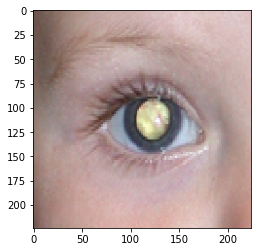

In [161]:
predict_images(model, 'multiclass','dataset/Small-Retinoblastoma-Dataset/testing/retinoblastoma/retinoblastoma reflexo.jpg')

white eye = retinoblastoma ✅

Normal


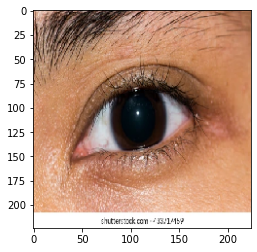

In [158]:
predict_images(model, 'multiclass', 'dataset/Small-Retinoblastoma-Dataset/testing/normal/close-asian-woman-eyes-flash-260nw-433717459.webp')

No reflection = Normal ✅

Normal


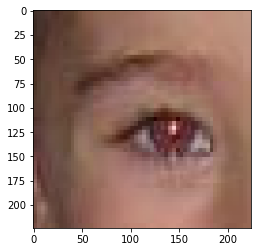

In [30]:
predict_images(model, 'multiclass','dataset/Retinoblastoma_dataset_2class/validation/normal/redeye.jpeg')

Red eye = Normal ✅

Normal


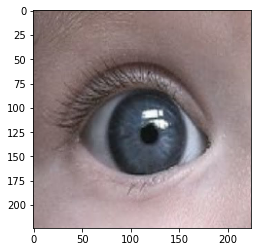

In [174]:
predict_images(model, 'multiclass','dataset/Retinoblastoma_dataset_2class/validation/normal/Young-children-can-see-them.jpeg')

No reflection = normal ✅

## Save Model
Saving the model for android deployment

In [ ]:
import pathlib

model.save("model_Basedvgg-3_multiclass.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# tflite_model_file = pathlib.Path("/content/tflite")
# tflite_model_file.write_bytes(tflite_model)

# Save the model.
with open('model_VGGBased-3_multiclass.tflite', 'wb') as f:
  f.write(tflite_model)